# Assessment of Cubic Equations of State: Machine Learning for Rich Carbon-Dioxide Systems

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import tensor
import torchvision
from torch.utils.data import Dataset
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import pr

In [50]:
#I don't know the format of data storage so far but now i assume a table. When we know i will complete the part
#the class is for data preparation and initializing dataset 
class Gas_dataset(Dataset):
    '''generation - which NN approach is used (may be we will need to load dataset differently)'''
    def __init__(self, path: str, generation: int, split: str, train_size = 0.8, stage_2nd=False, normal=False):
        super().__init__()
        
        assert split in ['train', 'test'] 
        self.normal =normal
        self.split = split
        self.path = path
        self.full_df = pd.read_csv(self.path, sep='\t')
        if generation == 1:
            self.need_df = self.full_df[['P_Mpa', 'Temp', 'x_CO2', 'density']]
        elif generation == 3:
            self.need_df = self.full_df[['P_Mpa', 'Temp', 'x_CO2', 'density', 'mix_viscosity']]
        elif generation == 4:
            self.need_df = self.full_df[['P_Mpa', 'Temp', 'x_CO2', 'density', 'mix_viscosity']]
        elif generation == 6:
            self.need_df = self.full_df[['a_mix', 'b_mix', 'p_red', 't_red', 'Z', 'density']]
        self.train_df, self.test_df = train_test_split(self.need_df, train_size=train_size)
        self.generation = generation
        self.stage_2nd = stage_2nd
        
        if split == 'train':
            if normal==False:
                self.target_t = tensor(self.train_df.values)
            else:
                self.target_t = normalize(tensor(self.train_df.values), dim=1)
        else:
            if normal==False:
                self.target_t = tensor(self.test_df.values)
            else:
                self.target_t = normalize(tensor(self.test_df.values))
    
    def __len__(self):
        return self.target_t.shape[0]
    
    
    def __getitem__(self, ind: int): 
        if self.generation == 1:
            self.features = self.target_t[:, 0:3][ind]
            self.labels = self.target_t[:,3][ind]

        elif self.generation == 3:
            self.features = self.target_t[:, 0:3][ind]
            self.labels = self.target_t[:, 3:][ind]

        elif self.generation == 4 and not self.stage_2nd:
            self.features = self.target_t[:,0:3][ind]
            self.labels = self.target_t[:,3][ind]
        elif self.generation == 4 and self.stage_2nd:
            self.features = self.target_t[:,0:4][ind]
            self.labels = self.target_t[:,4][ind]
        elif self.generation == 6:
            self.features = self.target_t[:,0:-1][ind]
            self.labels = self.target_t[:,-1][ind]
            
        return self.features, self.labels

In [21]:
# training functions. Most probably we will write a class for convinience 
def epoch_train(loader, nn, loss_f, opt):  
        
    batches_loss = []
    density_metric = []
    viscosity_metric =[]
    nn.train(True)
    loss = 0
    
    for i, data in enumerate(loader):
        feat, labels = data #unpack batch

        feat = feat.to(device, dtype=float)
        labels = labels.to(device, dtype=float)

        opt.zero_grad()
        
        pred = nn(feat).squeeze() #to get rid of one empty dim

        loss = loss_f(pred, labels)
        
        loss.backward()
        opt.step()
        batches_loss.append(loss.item())

        metric = torch.abs((labels - pred) / (labels)) * 100 #compute absolute relative deviation for a pair pred-label,%
        if len(labels.shape) == 1:
            density_metric.append(torch.mean(metric)) #add batch mean
        else:
            density_metric.append(torch.mean(metric[:,0]))
            viscosity_metric.append(torch.mean(metric[:,1]))

    if len(labels.shape) == 1:
        return torch.mean(torch.tensor(batches_loss)), \
        torch.mean(torch.tensor(density_metric))
    else:
        return torch.mean(torch.tensor(batches_loss)), torch.mean(torch.tensor(density_metric)), \
            torch.mean(torch.tensor(viscosity_metric))
    
def epoch_test(loader, nn, loss_f):

    nn.eval()

    batches_loss = []
    density_metric = []
    viscosity_metric =[]
    for i, data in enumerate(loader):
        feat, labels = data #unpack batch
        
        feat = feat.float() #to solve Input type (torch.cuda.ByteTensor) 
        
        feat = feat.to(device, dtype=float)
        labels = labels.to(device, dtype=float)
        pred = nn(feat).squeeze()
        
        loss = loss_f(pred, labels)
        batches_loss.append(loss.item())
        
        metric = torch.abs((labels - pred) / (labels)) * 100
        if len(labels.shape) == 1:
            density_metric.append(torch.mean(metric)) #add batch mean
        else:
            density_metric.append(torch.mean(metric[:,0]))
            viscosity_metric.append(torch.mean(metric[:,1]))
    if len(labels.shape) == 1:
    
        return torch.mean(torch.tensor(batches_loss)), \
        torch.mean(torch.tensor(density_metric))
    else:
        return torch.mean(torch.tensor(batches_loss)), torch.mean(torch.tensor(density_metric)), \
            torch.mean(torch.tensor(viscosity_metric))
    
def train(train_loader, test_loader, nn, loss_f, opt, n_epochs=50, label_len=1):
    # scheduler = ReduceLROnPlateau(optimizer=opt, mode='min')
    train_loss_lst =[]
    test_loss_lst = []
    if label_len == 1:
        for epoch in tqdm(range(n_epochs)):
            train_loss, train_ard = epoch_train(train_loader, nn, loss_f, opt)
            test_loss, test_ard = epoch_test(test_loader, nn, loss_f)
            train_loss_lst.append(train_loss)
            test_loss_lst.append(test_loss)
            if epoch % 5 == 0:
                print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train ARD: {train_ard:.2f}; ' + 
                    f'test loss: {test_loss:.3f}; test ARD: {test_ard:.2f}')
    else:
        for epoch in tqdm(range(n_epochs)):
            train_loss, tr_den_ard, tr_visc_ard = epoch_train(train_loader, nn, loss_f, opt)
            test_loss, te_den_ard, te_visc_ard = epoch_test(test_loader, nn, loss_f)
            if epoch % 5 == 0:
                print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}|| train dens ard: {tr_den_ard:.2f}|| ' + 
                    f'test loss: {test_loss:.3f}; test dens ard: {te_den_ard:.2f}|| ' +
                    f'train visc ard: {tr_visc_ard:.2f}|| test visc ard: {te_visc_ard:.2f}')
    return train_loss_lst, test_loss_lst

In [45]:
class Gen_1_NN(torch.nn.Module):
    def __init__(self): 
        super(Gen_1_NN, self).__init__()
        # self.input_dim = input_dim
        #some linear layers
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(), #depends on input data dim
            torch.nn.BatchNorm1d(3), #input pressure, temperature, composition
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3 * 3 * 3),
            torch.nn.BatchNorm1d(3 * 3 * 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3 * 3 * 3, 16 * 16),
#             torch.nn.Dropout(p = 0.2),
            torch.nn.BatchNorm1d(16 * 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16 * 16, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [46]:
path = os.getcwd() + '\\Data\\mix_df.csv'

In [56]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_set = Gas_dataset(split='train', generation=1, path=path)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, generator=torch.Generator(device=device))
test_set = Gas_dataset(split='test', generation=1, path=path)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

gen_1 = Gen_1_NN().to(device, dtype=float)
opt = torch.optim.Adam(gen_1.parameters(), lr=0.001)
loss_f = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=opt, mode='min')

In [57]:
train_loss_lst, test_loss_lst = train(train_loader, test_loader, gen_1, loss_f, opt, n_epochs=200, label_len=1) 

  1%|          | 2/200 [00:00<00:15, 12.38it/s]

[Epoch 1] train loss: 271084.406; train ARD: 99.63; test loss: 261419.141; test ARD: 99.41


  4%|▍         | 8/200 [00:00<00:14, 12.88it/s]

[Epoch 6] train loss: 247369.062; train ARD: 95.32; test loss: 237775.250; test ARD: 96.22


  6%|▌         | 12/200 [00:00<00:14, 13.27it/s]

[Epoch 11] train loss: 206155.266; train ARD: 90.92; test loss: 196302.688; test ARD: 91.81


  9%|▉         | 18/200 [00:01<00:13, 13.37it/s]

[Epoch 16] train loss: 159406.906; train ARD: 85.89; test loss: 156286.891; test ARD: 90.43


 12%|█▏        | 24/200 [00:01<00:13, 12.96it/s]

[Epoch 21] train loss: 114269.664; train ARD: 79.33; test loss: 114082.508; test ARD: 86.95


 14%|█▍        | 28/200 [00:02<00:12, 13.68it/s]

[Epoch 26] train loss: 81040.945; train ARD: 70.98; test loss: 78143.289; test ARD: 78.08


 17%|█▋        | 34/200 [00:02<00:11, 14.20it/s]

[Epoch 31] train loss: 60080.184; train ARD: 61.45; test loss: 62226.098; test ARD: 69.79


 19%|█▉        | 38/200 [00:02<00:11, 14.44it/s]

[Epoch 36] train loss: 46985.754; train ARD: 69.07; test loss: 29395.994; test ARD: 59.77


 22%|██▏       | 44/200 [00:03<00:10, 14.55it/s]

[Epoch 41] train loss: 40113.004; train ARD: 60.54; test loss: 32177.141; test ARD: 58.74


 24%|██▍       | 48/200 [00:03<00:11, 13.43it/s]

[Epoch 46] train loss: 33784.113; train ARD: 57.76; test loss: 20875.666; test ARD: 54.78


 27%|██▋       | 54/200 [00:04<00:10, 14.26it/s]

[Epoch 51] train loss: 25996.338; train ARD: 51.12; test loss: 18479.742; test ARD: 47.16


 29%|██▉       | 58/200 [00:04<00:09, 14.25it/s]

[Epoch 56] train loss: 18110.057; train ARD: 44.85; test loss: 10668.790; test ARD: 44.18


 31%|███       | 62/200 [00:04<00:09, 13.87it/s]

[Epoch 61] train loss: 26325.199; train ARD: 52.19; test loss: 10762.980; test ARD: 38.75


 34%|███▍      | 68/200 [00:05<00:10, 12.43it/s]

[Epoch 66] train loss: 18293.047; train ARD: 49.56; test loss: 8913.809; test ARD: 39.67


 37%|███▋      | 74/200 [00:05<00:09, 13.59it/s]

[Epoch 71] train loss: 25896.693; train ARD: 54.14; test loss: 11424.505; test ARD: 39.13


 39%|███▉      | 78/200 [00:05<00:08, 13.75it/s]

[Epoch 76] train loss: 24743.201; train ARD: 45.06; test loss: 8781.841; test ARD: 36.37


 42%|████▏     | 84/200 [00:06<00:07, 14.54it/s]

[Epoch 81] train loss: 18515.104; train ARD: 49.85; test loss: 8357.194; test ARD: 33.88


 44%|████▍     | 88/200 [00:06<00:08, 13.59it/s]

[Epoch 86] train loss: 19475.932; train ARD: 48.70; test loss: 8744.656; test ARD: 33.78


 47%|████▋     | 94/200 [00:07<00:08, 12.56it/s]

[Epoch 91] train loss: 14059.316; train ARD: 40.36; test loss: 8537.694; test ARD: 34.73


 49%|████▉     | 98/200 [00:07<00:07, 13.06it/s]

[Epoch 96] train loss: 19321.881; train ARD: 54.35; test loss: 9576.284; test ARD: 36.91


 51%|█████     | 102/200 [00:07<00:07, 13.04it/s]

[Epoch 101] train loss: 16373.885; train ARD: 45.91; test loss: 8238.461; test ARD: 30.65


 54%|█████▍    | 108/200 [00:08<00:06, 13.47it/s]

[Epoch 106] train loss: 11742.204; train ARD: 43.96; test loss: 7180.336; test ARD: 32.94


 57%|█████▋    | 114/200 [00:08<00:06, 13.92it/s]

[Epoch 111] train loss: 13557.226; train ARD: 40.03; test loss: 8980.814; test ARD: 28.72


 59%|█████▉    | 118/200 [00:08<00:06, 13.21it/s]

[Epoch 116] train loss: 13692.497; train ARD: 47.07; test loss: 6804.494; test ARD: 27.08


 61%|██████    | 122/200 [00:09<00:06, 12.90it/s]

[Epoch 121] train loss: 23381.439; train ARD: 48.60; test loss: 10235.526; test ARD: 35.34


 64%|██████▍   | 128/200 [00:09<00:05, 13.44it/s]

[Epoch 126] train loss: 16371.188; train ARD: 52.04; test loss: 4411.020; test ARD: 28.88


 67%|██████▋   | 134/200 [00:10<00:04, 14.13it/s]

[Epoch 131] train loss: 20438.828; train ARD: 52.65; test loss: 5447.952; test ARD: 22.32


 69%|██████▉   | 138/200 [00:10<00:04, 13.89it/s]

[Epoch 136] train loss: 21985.182; train ARD: 48.96; test loss: 5033.021; test ARD: 28.12


 71%|███████   | 142/200 [00:10<00:04, 12.49it/s]

[Epoch 141] train loss: 15428.764; train ARD: 44.19; test loss: 6060.789; test ARD: 28.11


 74%|███████▍  | 148/200 [00:11<00:03, 13.57it/s]

[Epoch 146] train loss: 8107.972; train ARD: 30.17; test loss: 6494.278; test ARD: 26.58


 76%|███████▌  | 152/200 [00:11<00:03, 13.72it/s]

[Epoch 151] train loss: 18353.637; train ARD: 47.94; test loss: 5387.360; test ARD: 24.14


 79%|███████▉  | 158/200 [00:11<00:02, 14.10it/s]

[Epoch 156] train loss: 17113.119; train ARD: 41.35; test loss: 9128.872; test ARD: 26.53


 82%|████████▏ | 164/200 [00:12<00:02, 14.28it/s]

[Epoch 161] train loss: 17798.846; train ARD: 47.45; test loss: 9504.016; test ARD: 24.71


 84%|████████▍ | 168/200 [00:12<00:02, 13.68it/s]

[Epoch 166] train loss: 18533.762; train ARD: 49.93; test loss: 5476.707; test ARD: 27.63


 86%|████████▌ | 172/200 [00:12<00:02, 12.49it/s]

[Epoch 171] train loss: 17593.342; train ARD: 43.14; test loss: 6899.780; test ARD: 22.25


 89%|████████▉ | 178/200 [00:13<00:01, 13.28it/s]

[Epoch 176] train loss: 19410.959; train ARD: 47.42; test loss: 8667.698; test ARD: 28.46


 92%|█████████▏| 184/200 [00:13<00:01, 13.80it/s]

[Epoch 181] train loss: 23080.693; train ARD: 73.52; test loss: 7645.678; test ARD: 30.26


 94%|█████████▍| 188/200 [00:14<00:00, 13.68it/s]

[Epoch 186] train loss: 14460.492; train ARD: 41.56; test loss: 4011.834; test ARD: 22.27


 96%|█████████▌| 192/200 [00:14<00:00, 12.19it/s]

[Epoch 191] train loss: 22504.744; train ARD: 52.33; test loss: 7079.764; test ARD: 27.98


 99%|█████████▉| 198/200 [00:14<00:00, 13.20it/s]

[Epoch 196] train loss: 19290.600; train ARD: 45.52; test loss: 6135.381; test ARD: 22.91


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


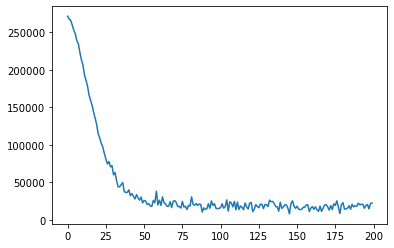

In [58]:
plt.plot(np.arange(len(train_loss_lst)),train_loss_lst)

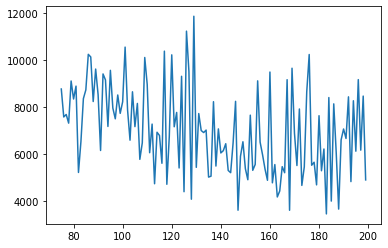

In [60]:
plt.plot(np.arange(len(test_loss_lst))[75:],test_loss_lst[75:])

# Validation

In [37]:
def valid(n_samples, model, generation=1, path='data//mix_df.csv'):
    need_df = pd.read_csv(path, sep='\t')
    pred_lst = []
    label_lst = []
    if generation == 1:
        target_feat = need_df[['P_Mpa', 'Temp', 'x_CO2']]
        target_lab = need_df[['density']]
        for _ in range(n_samples):
            x = np.random.randint(target_feat.shape[0])
            rand_feat = tensor(target_feat.iloc[x].values).unsqueeze(0)
            pred = model(rand_feat).squeeze()
            lab = tensor(target_lab.iloc[x].values)    
            pred_lst.append(pred.detach().numpy())
            label_lst.append(lab.detach().numpy())
        plt.plot(np.arange(len(pred_lst)), pred_lst, marker='o', color='b', label='Prediction')
        plt.plot(np.arange(len(label_lst)), label_lst, marker='x', color='r', label='Calculated')
        plt.legend()
    elif generation == 3:
        target_feat = need_df[['P_Mpa', 'Temp', 'x_CO2']]
        target_lab = need_df[['density', 'mix_viscosity']]
        for _ in range(n_samples):
            x = np.random.randint(target_feat.shape[0])
            rand_feat = tensor(target_feat.iloc[x].values).unsqueeze(0)
            pred = model(rand_feat).squeeze()
            lab = tensor(target_lab.iloc[x].values)    
            pred_lst.append(pred.detach().numpy())
            label_lst.append(lab.detach().numpy())
        pred_lst = np.array(pred_lst)
        label_lst = np.array(label_lst)
        fig, ax = plt.subplots(1, 2, figsize=(15,10))
        ax[0].plot(np.arange(len(pred_lst[:,0])), pred_lst[:,0], marker='o', color='b', label='Density_Prediction')
        ax[0].plot(np.arange(len(label_lst[:,0])), label_lst[:,0], marker='x', color='r', label='Density_Calculated')
        ax[1].plot(np.arange(len(pred_lst[:,1])), pred_lst[:,1], marker='o', color='b', label='Viscosity_Prediction')
        ax[1].plot(np.arange(len(label_lst[:,1])), label_lst[:,1], marker='x', color='r', label='Viscosity_Calculated')
        ax[0].legend()
        ax[1].legend()
    elif generation == 6:
        target_feat = need_df[['a_mix', 'b_mix', 'p_red', 't_red', 'Z']]
        target_lab = need_df[['density']]
        for _ in range(n_samples):
            x = np.random.randint(target_feat.shape[0])
            rand_feat = tensor(target_feat.iloc[x].values).unsqueeze(0)
            pred = model(rand_feat).squeeze()
            lab = tensor(target_lab.iloc[x].values)    
            pred_lst.append(pred.detach().numpy())
            label_lst.append(lab.detach().numpy())
        plt.plot(np.arange(len(pred_lst)), pred_lst, marker='o', color='b', label='Prediction')
        plt.plot(np.arange(len(label_lst)), label_lst, marker='x', color='r', label='Calculated')
        plt.legend()
        # return label_lst, pred_lst
    # elif generation == 4:
    #     self.need_df = self.full_df[['P_Mpa', 'Temp', 'x_CO2', 'density', 'mix_viscosity']]
    # elif generation == 6:
    #     self.need_df = self.full_df[['P_Mpa', 'Temp', 'x_CO2', 'a_mix', 'b_mix', 'p_red', 't_red', 'Z', 'density']]
    

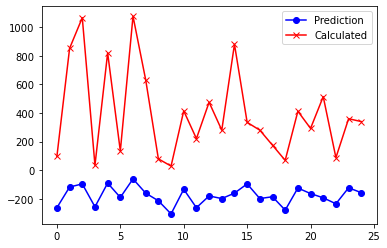

In [55]:
valid(25, gen_1)

In [2]:
x_df = pd.read_csv('data//mix_df.csv', sep='\t')
x_df.columns

Index(['P_Mpa', 'ro_mol', 'Z', 'Temp', 'Mr', 'x_CO2', 'density',
       'mix_viscosity', 'a_mix', 'b_mix', 'p_red', 't_red'],
      dtype='object')

In [16]:
class Gen_3_NN(torch.nn.Module):
    def __init__(self, input_dim=3): 
        super(Gen_3_NN, self).__init__()
        self.input_dim = input_dim
        #some linear layers
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(), #depends on input data dim
            torch.nn.BatchNorm1d(self.input_dim), #input pressure, temperature, composition
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3 * 3 * 3),
            torch.nn.BatchNorm1d(3 * 3 * 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3 * 3 * 3, 16 * 16),
#             torch.nn.Dropout(p = 0.2),
            torch.nn.BatchNorm1d(16 * 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16*16, 12 * 12),
#             torch.nn.Dropout(p = 0.2),
            torch.nn.BatchNorm1d(12 * 12),
            torch.nn.ReLU(),
            torch.nn.Linear(12 * 12, 2) #output is density and viscosity tensors
        )
    def forward(self, x):
        return self.layers(x)

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_set = Gas_dataset(split='train', generation=3, path=path)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, generator=torch.Generator(device=device))
test_set = Gas_dataset(split='test', generation=3, path=path)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

gen_3 = Gen_3_NN().to(device, dtype=float)
opt = torch.optim.Adam(gen_3.parameters(), lr=0.001)
loss_f = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=opt, mode='min')

In [24]:
train_loss_lst, test_loss_lst = train(train_loader, test_loader, gen_3, loss_f, opt, n_epochs=10, label_len=2) 

 20%|██        | 2/10 [00:00<00:01,  6.66it/s]

[Epoch 1] train loss: 9464.049|| train dens ard: 59.86|| test loss: 5349.918; test dens ard: 22.66|| train visc ard: 43.15|| test visc ard: 16.02


 70%|███████   | 7/10 [00:00<00:00,  6.83it/s]

[Epoch 6] train loss: 7079.990|| train dens ard: 34.20|| test loss: 6042.449; test dens ard: 16.61|| train visc ard: 30.35|| test visc ard: 12.16


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


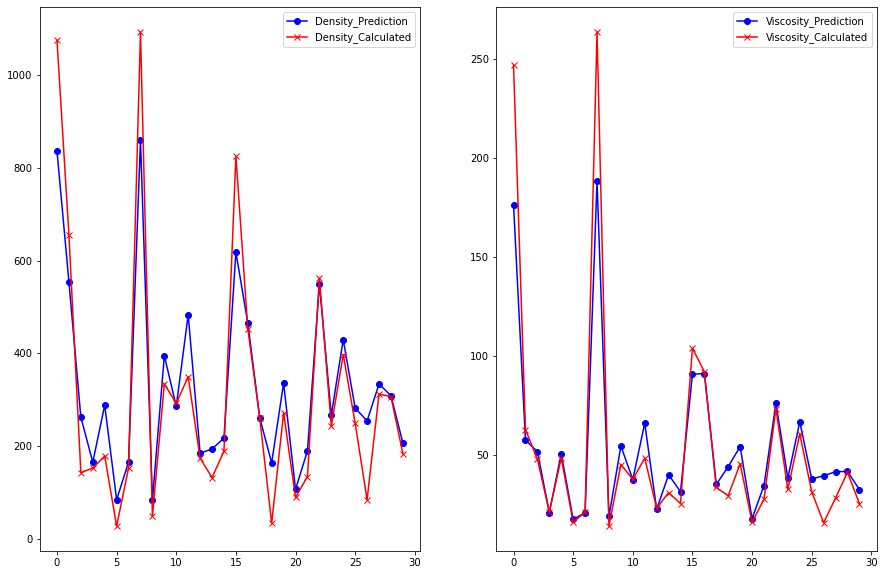

In [23]:
valid(30, gen_3, generation=3)

In [ ]:
#for second NN in gen_4 it's needed to have density as an input parameter obtained with NN having structure of Gen_1 
predicted_dens = []
for inp_par in training_data_array:
    dens_input = Gen_1_NN(inp_par)
    predicted_dens.append(dens_input)
predicted_dens = np.array(predicted_dens)


class Gen_4_NN(torch.nn.Module):
    def __init__(self, input_dim=3): -> None
        super(Gen_4_NN, self).__init__()
        self.input_dim = input_dim
        #some linear layers
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(), #depends on input data dim
            torch.nn.BatchNorm1d(self.input_dim), #input pressure, temperature, composition
            torch.nn.ReLU(),
            torch.nn.Linear(3, 3 * 3 * 3),
            torch.nn.BatchNorm1d(3 * 3 * 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3 * 3 * 3, 16 * 16),
#             torch.nn.Dropout(p = 0.2),
            torch.nn.BatchNorm1d(16 * 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16 * 16, 1)
        )
    def forward(self):
        return self.layers

In [28]:
class Gen_6_NN(torch.nn.Module):
    def __init__(self, input_dim=5):
        super(Gen_6_NN, self).__init__()
        self.input_dim = input_dim
        #some linear layers
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(), #depends on input data dim
            torch.nn.BatchNorm1d(self.input_dim), #input pressure, temperature, composition
            torch.nn.ReLU(),
            torch.nn.Linear(self.input_dim, 3 * 3 * 3),
            torch.nn.BatchNorm1d(3 * 3 * 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3 * 3 * 3, 16 * 16),
#             torch.nn.Dropout(p = 0.2),
            torch.nn.BatchNorm1d(16 * 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16 * 16, 1)
        )
    def forward(self, x):
        return self.layers(x)

In [39]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_set = Gas_dataset(split='train', generation=6, path=path)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, generator=torch.Generator(device=device))
test_set = Gas_dataset(split='test', generation=6, path=path)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

gen_6 = Gen_6_NN().to(device, dtype=float)
opt = torch.optim.Adam(gen_6.parameters(), lr=0.001)
loss_f = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=opt, mode='min')

In [41]:
train_loss_lst, test_loss_lst = train(train_loader, test_loader, gen_6, loss_f, opt, n_epochs=200, label_len=1)

  1%|          | 2/200 [00:00<00:18, 10.90it/s]

[Epoch 1] train loss: 26613.533; train ARD: 96.37; test loss: 28622.477; test ARD: 71.66


  4%|▍         | 8/200 [00:00<00:14, 12.82it/s]

[Epoch 6] train loss: 30145.361; train ARD: 88.83; test loss: 32956.832; test ARD: 76.83


  6%|▌         | 12/200 [00:01<00:17, 10.91it/s]

[Epoch 11] train loss: 37725.539; train ARD: 99.04; test loss: 34759.887; test ARD: 73.45


  9%|▉         | 18/200 [00:01<00:14, 12.42it/s]

[Epoch 16] train loss: 34724.180; train ARD: 101.44; test loss: 28218.205; test ARD: 78.10


 11%|█         | 22/200 [00:01<00:14, 12.39it/s]

[Epoch 21] train loss: 32821.430; train ARD: 96.38; test loss: 28193.826; test ARD: 75.38


 14%|█▍        | 28/200 [00:02<00:14, 12.27it/s]

[Epoch 26] train loss: 42195.363; train ARD: 105.90; test loss: 26053.834; test ARD: 73.36


 17%|█▋        | 34/200 [00:02<00:12, 13.61it/s]

[Epoch 31] train loss: 42656.023; train ARD: 107.30; test loss: 30400.967; test ARD: 76.91


 19%|█▉        | 38/200 [00:03<00:11, 13.89it/s]

[Epoch 36] train loss: 36577.273; train ARD: 102.03; test loss: 32113.619; test ARD: 78.72


 21%|██        | 42/200 [00:03<00:11, 13.54it/s]

[Epoch 41] train loss: 37367.637; train ARD: 107.31; test loss: 29401.678; test ARD: 75.69


 24%|██▍       | 48/200 [00:03<00:12, 12.25it/s]

[Epoch 46] train loss: 28702.623; train ARD: 92.37; test loss: 29174.787; test ARD: 79.85


 27%|██▋       | 54/200 [00:04<00:10, 14.16it/s]

[Epoch 51] train loss: 26814.242; train ARD: 96.13; test loss: 33150.895; test ARD: 75.27


 29%|██▉       | 58/200 [00:04<00:10, 13.42it/s]

[Epoch 56] train loss: 40810.188; train ARD: 109.73; test loss: 29739.221; test ARD: 75.92


 31%|███       | 62/200 [00:04<00:09, 13.85it/s]

[Epoch 61] train loss: 34002.559; train ARD: 100.55; test loss: 33391.434; test ARD: 80.51


 34%|███▍      | 68/200 [00:05<00:10, 12.89it/s]

[Epoch 66] train loss: 34200.254; train ARD: 92.17; test loss: 25879.959; test ARD: 76.97


 36%|███▌      | 72/200 [00:05<00:10, 12.55it/s]

[Epoch 71] train loss: 31767.305; train ARD: 96.14; test loss: 28240.010; test ARD: 77.29


 39%|███▉      | 78/200 [00:06<00:09, 12.77it/s]

[Epoch 76] train loss: 31799.057; train ARD: 94.94; test loss: 31592.656; test ARD: 74.82


 41%|████      | 82/200 [00:06<00:09, 12.88it/s]

[Epoch 81] train loss: 32248.662; train ARD: 87.72; test loss: 27495.869; test ARD: 72.27


 44%|████▍     | 88/200 [00:06<00:08, 13.38it/s]

[Epoch 86] train loss: 31756.238; train ARD: 92.47; test loss: 29163.721; test ARD: 72.91


 47%|████▋     | 94/200 [00:07<00:08, 13.09it/s]

[Epoch 91] train loss: 25379.887; train ARD: 86.50; test loss: 28006.514; test ARD: 72.82


 49%|████▉     | 98/200 [00:07<00:07, 12.86it/s]

[Epoch 96] train loss: 35325.988; train ARD: 102.86; test loss: 32078.029; test ARD: 73.83


 51%|█████     | 102/200 [00:07<00:07, 12.78it/s]

[Epoch 101] train loss: 33706.285; train ARD: 96.17; test loss: 26560.516; test ARD: 75.09


 54%|█████▍    | 108/200 [00:08<00:06, 13.76it/s]

[Epoch 106] train loss: 35228.910; train ARD: 93.23; test loss: 27040.432; test ARD: 74.60


 57%|█████▋    | 114/200 [00:08<00:06, 13.42it/s]

[Epoch 111] train loss: 41139.449; train ARD: 104.68; test loss: 28452.572; test ARD: 75.14


 59%|█████▉    | 118/200 [00:09<00:06, 13.19it/s]

[Epoch 116] train loss: 34747.289; train ARD: 93.41; test loss: 32923.031; test ARD: 76.08


 61%|██████    | 122/200 [00:09<00:06, 12.90it/s]

[Epoch 121] train loss: 35971.039; train ARD: 97.48; test loss: 27125.080; test ARD: 81.84


 64%|██████▍   | 128/200 [00:09<00:05, 13.43it/s]

[Epoch 126] train loss: 30453.744; train ARD: 87.34; test loss: 26783.439; test ARD: 71.60


 66%|██████▌   | 132/200 [00:10<00:05, 13.56it/s]

[Epoch 131] train loss: 46190.598; train ARD: 106.13; test loss: 25904.178; test ARD: 74.40


 68%|██████▊   | 136/200 [00:10<00:04, 13.93it/s]

[Epoch 136] train loss: 43115.512; train ARD: 112.40; test loss: 25679.439; test ARD: 69.41


 72%|███████▏  | 144/200 [00:11<00:04, 13.68it/s]

[Epoch 141] train loss: 33876.973; train ARD: 96.02; test loss: 29437.842; test ARD: 79.40


 74%|███████▍  | 148/200 [00:11<00:03, 13.38it/s]

[Epoch 146] train loss: 32060.213; train ARD: 95.14; test loss: 30646.959; test ARD: 75.25


 76%|███████▌  | 152/200 [00:11<00:03, 12.21it/s]

[Epoch 151] train loss: 31232.127; train ARD: 91.41; test loss: 29396.186; test ARD: 73.30


 79%|███████▉  | 158/200 [00:12<00:03, 10.89it/s]

[Epoch 156] train loss: 46899.789; train ARD: 104.60; test loss: 32172.549; test ARD: 78.37


 81%|████████  | 162/200 [00:12<00:03, 10.35it/s]

[Epoch 161] train loss: 33679.074; train ARD: 93.16; test loss: 28452.533; test ARD: 79.57


 84%|████████▍ | 168/200 [00:13<00:03, 10.45it/s]

[Epoch 166] train loss: 29245.402; train ARD: 89.30; test loss: 26976.131; test ARD: 73.11


 86%|████████▌ | 172/200 [00:13<00:02, 10.82it/s]

[Epoch 171] train loss: 32142.002; train ARD: 90.68; test loss: 29945.146; test ARD: 78.95


 89%|████████▉ | 178/200 [00:14<00:01, 11.22it/s]

[Epoch 176] train loss: 36487.277; train ARD: 99.54; test loss: 30974.219; test ARD: 82.58


 91%|█████████ | 182/200 [00:14<00:01,  9.13it/s]

[Epoch 181] train loss: 33626.941; train ARD: 98.01; test loss: 28506.537; test ARD: 73.38


 94%|█████████▍| 188/200 [00:15<00:01,  9.43it/s]

[Epoch 186] train loss: 29008.582; train ARD: 92.20; test loss: 28492.158; test ARD: 71.39


 96%|█████████▋| 193/200 [00:15<00:00, 10.03it/s]

[Epoch 191] train loss: 36374.852; train ARD: 100.87; test loss: 28958.703; test ARD: 72.71


 98%|█████████▊| 197/200 [00:16<00:00, 10.56it/s]

[Epoch 196] train loss: 35556.656; train ARD: 95.15; test loss: 31854.799; test ARD: 72.75


100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


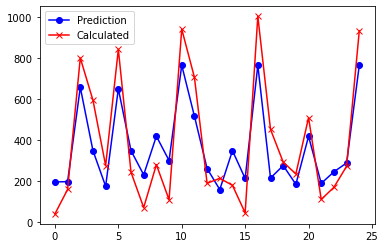

In [42]:
valid(25, gen_6, generation=6)

# Experiments

In [256]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_set = Gas_dataset(split='train', generation=1, path=path)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, generator=torch.Generator(device=device))
test_set = Gas_dataset(split='test', generation=1, path=path)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

gen_1 = Gen_1_NN().to(device, dtype=float)
opt = torch.optim.Adam(gen_1.parameters(), lr=0.001)
loss_f = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer=opt, mode='min')

In [257]:
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    sample_label = test_labels

In [258]:
sample_label.shape

torch.Size([7])

In [259]:
pred = gen_1(sample_image).squeeze()

In [260]:
metric = torch.abs((sample_label - pred) / (sample_label))

In [261]:
metric

tensor([0.9977, 0.9987, 1.0003, 1.0006, 1.0000, 0.9990, 0.9996],
       dtype=torch.float64, grad_fn=<AbsBackward0>)

In [263]:
pred

tensor([ 0.1396,  0.0874, -0.3849, -0.5580,  0.0158,  0.0923,  0.3799],
       dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [265]:
metric.shape

torch.Size([7])